In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2fa118381b7f52a88f31b815ba77a917b47fe978a88e89deace8e3f76967e324
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
# =========================
# 1️ 기본/유틸리티 라이브러리
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# =========================
# 2️ 데이터 전처리 및 평가 도구
# =========================
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# =========================
# 3️ 딥러닝 모델 (TensorFlow / Keras)
# =========================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, MaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# =========================
# 4️ 앙상블 모델 (XGBoost)
# =========================
import xgboost as xgb

# =========================
# 5 시계열 기술지표 (보조 feature)
# =========================
import ta  # RSI, MACD, BollingerBand 등

In [3]:
# =========================
# 1️ 데이터 로드
# =========================
# 파일 경로는 실제 환경에 맞게 수정해주세요.
try:
    df = pd.read_csv('/content/drive/MyDrive/Bitcoin/btc_1d_data_2018_to_2025.csv')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 임시 더미 데이터를 생성합니다.")
    dates = pd.to_datetime(pd.date_range(start='2018-01-01', periods=2000, freq='D'))
    data = np.random.rand(2000, 5) * 40000 + 10000
    df = pd.DataFrame(data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
    df['Open time'] = dates

# =========================
# 2️ 시간 컬럼 처리 및 특성 선택
# =========================
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.set_index('Open time')
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df_numeric = df[features]

# =========================
# 기술적 보조지표 추가
# =========================

# # 3-1. 이동 평균 (Moving Average) - 추세 파악
# df_numeric['SMA_20'] = ta.trend.sma_indicator(df_numeric['Close'], window=10) # 10일 단순 이동 평균
# df_numeric['EMA_20'] = ta.trend.ema_indicator(df_numeric['Close'], window=10) # 10일 지수 이동 평균

# # 3-2. 상대강도지수 (RSI) - 과매수/과매도 파악
# df_numeric['RSI_14'] = ta.momentum.rsi(df_numeric['Close'], window=14)

# # 3-3. MACD - 추세의 강도와 방향성 파악
# macd = ta.trend.MACD(close=df_numeric['Close'], window_slow=26, window_fast=12, window_sign=9)
# df_numeric['MACD'] = macd.macd() # MACD 선
# df_numeric['MACD_Signal'] = macd.macd_signal() # Signal 선

# =========================
# 3️ 결측치 확인 (데이터에 따라 필요시 처리)
# =========================
print(f"결측치 총합: {df_numeric.isna().sum().sum()}")
df_numeric.dropna(inplace=True)

features = df_numeric.columns.tolist()

# =========================
# 4️ 데이터 스케일링 (MinMaxScaler)
# =========================
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric),
                         columns=features,
                         index=df_numeric.index)

print("데이터 전처리 완료. 스케일링된 데이터 샘플:")
df_scaled.head()

파일을 찾을 수 없습니다. 임시 더미 데이터를 생성합니다.
결측치 총합: 0
데이터 전처리 완료. 스케일링된 데이터 샘플:


,Open,High,Low,Close,Volume
Open time,,,,,
2018-01-01,0.491798,0.432929,0.762914,0.549483,0.984837
2018-01-02,0.602606,0.052854,0.582233,0.851349,0.473376
2018-01-03,0.744061,0.519156,0.503186,0.084238,0.806752
2018-01-04,0.671259,0.441622,0.154811,0.230107,0.184055
2018-01-05,0.731894,0.799753,0.078867,0.761948,0.628220


In [4]:
def create_window_sequences(data, seq_len, predict_col='Close'):
    """
    LSTM 및 CNN 모델 입력을 위한 시계열 시퀀스 데이터를 생성합니다.
    (samples, timesteps, features) 형태의 3D 배열을 반환합니다.
    """
    values = data.values
    X, y = [], []
    predict_idx = data.columns.get_loc(predict_col)

    for i in range(len(values) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len, predict_idx])

    return np.array(X), np.array(y)

# 하이퍼파라미터
SEQ_LEN = 6 # 과거 6일 데이터를 보고 다음 날 예측
TARGET_COL = 'Close'

# 전체 데이터를 시퀀스 형태로 변환
X_seq_all, y_all = create_window_sequences(df_scaled, SEQ_LEN, TARGET_COL)
print(f"전체 시퀀스 데이터 Shape: X={X_seq_all.shape}, y={y_all.shape}")

전체 시퀀스 데이터 Shape: X=(1994, 6, 5), y=(1994,)


In [5]:
def build_lstm_model(input_shape, l2_reg=0.001, dropout_rate=0.161):
    """
    과적합 방지를 위한 규제 기법이 적용된 순수 LSTM 모델을 구축합니다.
    """
    inputs = Input(shape=input_shape)

    # LSTM 레이어
    x = LSTM(96, activation='linear', kernel_regularizer=l2(l2_reg))(inputs)

    # Dropout 레이어
    x = Dropout(dropout_rate)(x)

    # 출력 레이어
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

    return model

In [6]:
def build_cnn_lstm_model(input_shape, l2_reg=0.001, dropout_rate=0.161):
    """
    과적합 방지를 위한 규제 기법이 적용된 CNN-LSTM 모델을 구축합니다.
    - L2 규제: 가중치가 너무 커지는 것을 방지하여 모델 복잡도를 제어합니다.
    - Dropout: 학습 시 일부 뉴런을 무작위로 비활성화하여 과적합을 방지합니다.
    """
    inputs = Input(shape=input_shape)

    # 1D CNN 레이어: 시퀀스 내의 지역적 패턴 추출
    x = Conv1D(filters=64, kernel_size=3, activation='linear', kernel_regularizer=l2(l2_reg))(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM 레이어: 시간적 순서 학습
    x = LSTM(96, activation='linear')(x)

    # Dropout 레이어
    x = Dropout(dropout_rate)(x)

    # 출력 레이어
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mae'])

    return model

# 모델 구조 확인
# (데이터 분할 후 실제 학습 시 input_shape가 결정됩니다)
# temp_model = build_cnn_lstm_model(input_shape=(SEQ_LEN, len(features)))
# temp_model.summary()

In [7]:
# =========================
# 워크 포워드 교차 검증 설정 (수정)
# =========================
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# 결과를 저장할 리스트 (y_pred_lstm_list 추가)
y_true_list = []
y_pred_lstm_list = []
y_pred_cnn_list = []
y_pred_xgb_list = []
y_pred_stack_list = []

# 검증/테스트 손실 리스트
val_losses_lstm_mse, val_losses_lstm_mae = [], []
test_losses_lstm_mse, test_losses_lstm_mae = [], []
val_losses_cnn_mse, val_losses_cnn_mae = [], []
test_losses_cnn_mse, test_losses_cnn_mae = [], []

fold = 0
for train_index, test_index in tscv.split(X_seq_all):
    fold += 1
    print(f"===== FOLD {fold}/{N_SPLITS} =====")

    # 데이터 분할
    X_train_seq, X_test_seq = X_seq_all[train_index], X_seq_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    # XGBoost는 2차원 형태 데이터 학습을 못하기 떄문에 1차원으로 펼쳐줌.
    X_train_tab = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_test_tab = X_test_seq.reshape(X_test_seq.shape[0], -1)

    # =========================
    # Base 모델 학습
    # =========================
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # 1. LSTM 모델 학습
    print("LSTM 모델 학습 중...")
    lstm_model = build_lstm_model(input_shape=(SEQ_LEN, len(features)))
    lstm_model.fit(X_train_seq, y_train, epochs=100, batch_size=32, verbose=0,
                   validation_split=0.1, callbacks=[early_stop])

    # LSTM 손실 계산 및 리스트 추가
    val_mse, val_mae = lstm_model.evaluate(X_train_seq, y_train, verbose=0)
    test_mse, test_mae = lstm_model.evaluate(X_test_seq, y_test, verbose=0)
    val_losses_lstm_mse.append(val_mse)
    val_losses_lstm_mae.append(val_mae)
    test_losses_lstm_mse.append(test_mse)
    test_losses_lstm_mae.append(test_mae)

    # 2. CNN-LSTM 모델 학습
    print("CNN-LSTM 모델 학습 중...")
    cnn_lstm_model = build_cnn_lstm_model(input_shape=(SEQ_LEN, len(features)))
    cnn_lstm_model.fit(X_train_seq, y_train, epochs=100, batch_size=32, verbose=0,
                       validation_split=0.1, callbacks=[early_stop])

     # CNN-LSTM 손실 계산 및 리스트 추가
    val_mse, val_mae = cnn_lstm_model.evaluate(X_train_seq, y_train, verbose=0)
    test_mse, test_mae = cnn_lstm_model.evaluate(X_test_seq, y_test, verbose=0)
    val_losses_cnn_mse.append(val_mse)
    val_losses_cnn_mae.append(val_mae)
    test_losses_cnn_mse.append(test_mse)
    test_losses_cnn_mae.append(test_mae)



    # 3. XGBoost 모델 학습
    print("XGBoost 모델 학습 중...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train_tab, y_train)

    # =========================
    # Base 모델 예측값 생성 (pred_lstm 추가)
    # =========================
    pred_lstm = lstm_model.predict(X_test_seq)
    pred_cnn_lstm = cnn_lstm_model.predict(X_test_seq)
    pred_xgb = xgb_model.predict(X_test_tab).reshape(-1, 1)

    # =========================
    # 스태킹 데이터셋 구성 (lstm 예측 추가)
    # =========================
    train_pred_lstm = lstm_model.predict(X_train_seq)
    train_pred_cnn = cnn_lstm_model.predict(X_train_seq)
    train_pred_xgb = xgb_model.predict(X_train_tab).reshape(-1, 1)

    # 이제 3개 모델의 예측을 입력으로 사용
    stacked_X_train = np.hstack([train_pred_lstm, train_pred_cnn, train_pred_xgb])
    stacked_X_test = np.hstack([pred_lstm, pred_cnn_lstm, pred_xgb])

    # =========================
    # 메타 모델 학습 및 예측
    # =========================
    print("메타 모델 (스태킹) 학습 중...")
    meta_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
    meta_model.fit(stacked_X_train, y_train)
    pred_stack = meta_model.predict(stacked_X_test)

    # =========================
    # 결과 저장 (y_pred_lstm_list 추가)
    # =========================
    y_true_list.extend(y_test)
    y_pred_lstm_list.extend(pred_lstm.flatten())
    y_pred_cnn_list.extend(pred_cnn_lstm.flatten())
    y_pred_xgb_list.extend(pred_xgb.flatten())
    y_pred_stack_list.extend(pred_stack)

print("\n워크 포워드 검증 및 스태킹 앙상블 완료.")

===== FOLD 1/5 =====
LSTM 모델 학습 중...
CNN-LSTM 모델 학습 중...
XGBoost 모델 학습 중...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
메타 모델 (스태킹) 학습 중...
===== FOLD 2/5 =====
LSTM 모델 학습 중...
CNN-LSTM 모델 학습 중...
XGBoost 모델 학습 중...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
메타 모델 (스태킹) 학습 중...
===== FOLD 3/5 =====
LSTM 모델 학습 중...
CNN-LSTM 모델 학습 중...
XGBoost 모델 학습 중...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
메타 모델 (스태킹) 학습 중...
===== FOLD 4/5 =====
LSTM 모델 학습 중...
CNN-LSTM 모델 학습 중...
XGBoost 모델 학습 중...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
메

In [8]:
lstm_model.summary()
cnn_lstm_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 6, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 96)                  │          39,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,797 (460.15 KB)

 Trainable params: 39,265 (153.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 78,532 (306.77 KB)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 6, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4, 64)               │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 96)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,837 (737.65 KB)

 Trainable params: 62,945 (245.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 125,892 (491.77 KB)


--- [비교용] 정규화된 데이터 기준 최종 성능 평가 ---
LSTM 모델 평균 검증 손실(MSE): 0.0867, MAE: 0.2546
LSTM 모델 평균 테스트 손실(MSE): 0.0849, MAE: 0.2506
CNN-LSTM 모델 평균 검증 손실(MSE): 0.1019, MAE: 0.2624
CNN-LSTM 모델 평균 테스트 손실(MSE): 0.0976, MAE: 0.2556
XGBoost 모델 최종 테스트 손실(MSE) : 0.1008, MAE: 0.2663
스태킹 앙상블 모델 최종 테스트 손실(MSE) : 0.1010, MAE: 0.2666


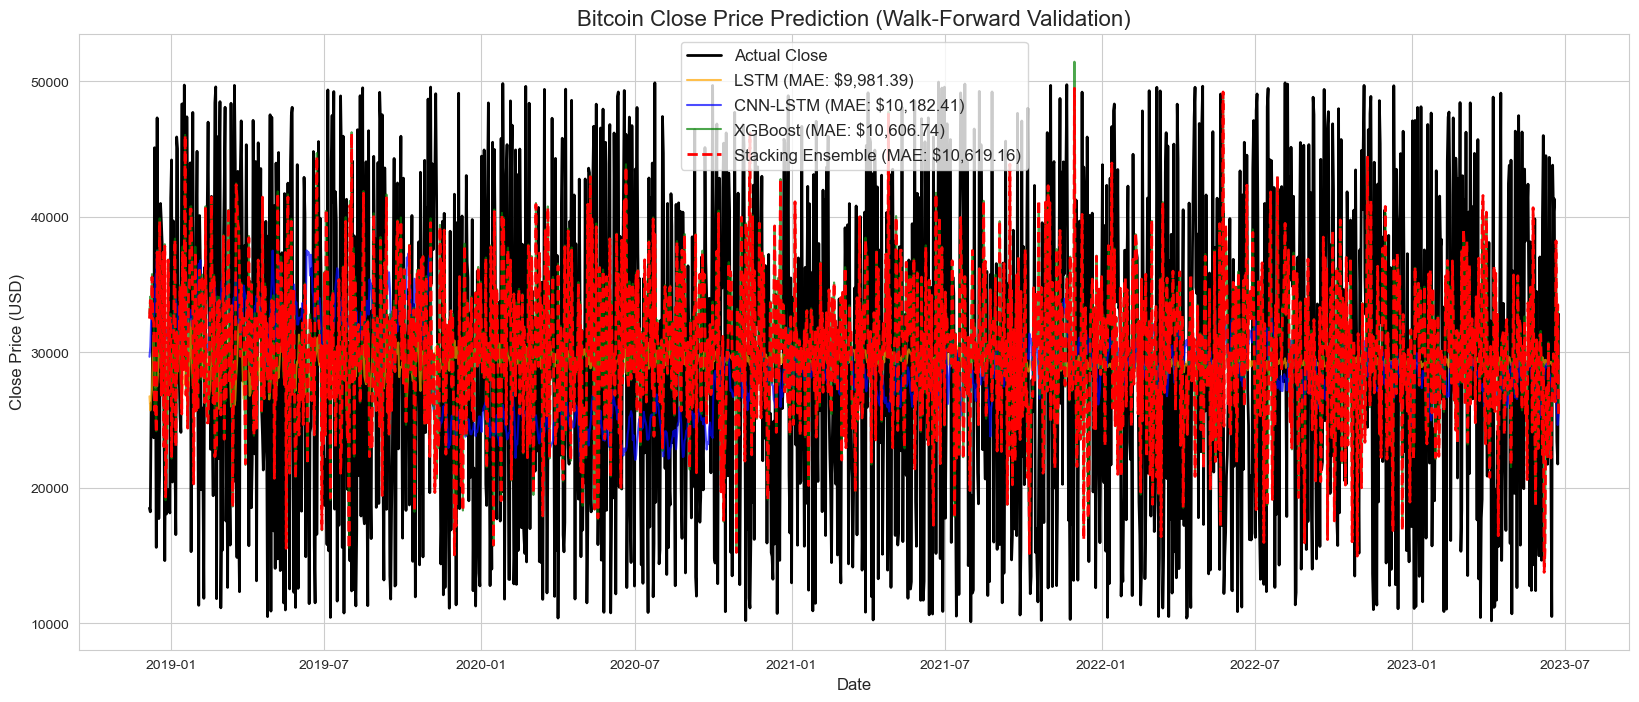

In [9]:
def inverse_transform_predictions(predictions, scaler, target_col_idx):
    """ 예측값을 원래 스케일로 복원합니다. """
    pred_reshaped = np.zeros((len(predictions), scaler.n_features_in_))
    pred_reshaped[:, target_col_idx] = predictions
    return scaler.inverse_transform(pred_reshaped)[:, target_col_idx]

# 타겟 변수('Close')의 인덱스 찾기
target_idx = df_scaled.columns.get_loc(TARGET_COL)

# 각 예측 결과를 원래 가격 스케일로 복원 (y_pred_lstm_real 추가)
y_true_real = inverse_transform_predictions(y_true_list, scaler, target_idx)
y_pred_lstm_real = inverse_transform_predictions(y_pred_lstm_list, scaler, target_idx)
y_pred_cnn_real = inverse_transform_predictions(y_pred_cnn_list, scaler, target_idx)
y_pred_xgb_real = inverse_transform_predictions(y_pred_xgb_list, scaler, target_idx)
y_pred_stack_real = inverse_transform_predictions(y_pred_stack_list, scaler, target_idx)

# =========================
# 1️ 성능 지표(MAE) 계산 (mae_lstm 추가)
# =========================
mae_lstm = mean_absolute_error(y_true_real, y_pred_lstm_real)
mae_cnn = mean_absolute_error(y_true_real, y_pred_cnn_real)
mae_xgb = mean_absolute_error(y_true_real, y_pred_xgb_real)
mae_stack = mean_absolute_error(y_true_real, y_pred_stack_real)

# print("\n--- 최종 모델 성능 평가 (MAE) ---")
# print(f"LSTM 모델 MAE: ${mae_lstm:,.2f}")
# print(f"CNN-LSTM 모델 MAE: ${mae_cnn:,.2f}")
# print(f"XGBoost 모델 MAE : ${mae_xgb:,.2f}")
# print(f"스태킹 앙상블 모델 MAE : ${mae_stack:,.2f}")

# =========================
# 정규화된 데이터 기준 성능 지표(MSE, MAE) 계산 (기존 방식과 비교용)
# =========================
# y_true_list와 각 모델의 예측 리스트는 스케일링된 값(0~1)을 가지고 있습니다.


# LSTM
# mse_lstm_scaled = mean_squared_error(y_true_list, y_pred_lstm_list)
# mae_lstm_scaled = mean_absolute_error(y_true_list, y_pred_lstm_list)

# CNN-LSTM
# mse_cnn_scaled = mean_squared_error(y_true_list, y_pred_cnn_list)
# mae_cnn_scaled = mean_absolute_error(y_true_list, y_pred_cnn_list)

# XGBoost
mse_xgb_scaled = mean_squared_error(y_true_list, y_pred_xgb_list)
mae_xgb_scaled = mean_absolute_error(y_true_list, y_pred_xgb_list)

# Stacking Ensemble
mse_stack_scaled = mean_squared_error(y_true_list, y_pred_stack_list)
mae_stack_scaled = mean_absolute_error(y_true_list, y_pred_stack_list)

# 평균 검증/테스트 손실(MSE) 계산
avg_val_loss_lstm_mse = np.mean(val_losses_lstm_mse)
avg_val_loss_lstm_mae = np.mean(val_losses_lstm_mae)
avg_test_loss_lstm_mse = np.mean(test_losses_lstm_mse)
avg_test_loss_lstm_mae = np.mean(test_losses_lstm_mae)

avg_val_loss_cnn_mse = np.mean(val_losses_cnn_mse)
avg_val_loss_cnn_mae = np.mean(val_losses_cnn_mae)
avg_test_loss_cnn_mse = np.mean(test_losses_cnn_mse)
avg_test_loss_cnn_mae = np.mean(test_losses_cnn_mae)

print("\n--- [비교용] 정규화된 데이터 기준 최종 성능 평가 ---")
# LSTM
print(f"LSTM 모델 평균 검증 손실(MSE): {avg_val_loss_lstm_mse:.4f}, MAE: {avg_val_loss_lstm_mae:.4f}")
print(f"LSTM 모델 평균 테스트 손실(MSE): {avg_test_loss_lstm_mse:.4f}, MAE: {avg_test_loss_lstm_mae:.4f}")
# CNN-LSTM
print(f"CNN-LSTM 모델 평균 검증 손실(MSE): {avg_val_loss_cnn_mse:.4f}, MAE: {avg_val_loss_cnn_mae:.4f}")
print(f"CNN-LSTM 모델 평균 테스트 손실(MSE): {avg_test_loss_cnn_mse:.4f}, MAE: {avg_test_loss_cnn_mae:.4f}")
# XGBoost
print(f"XGBoost 모델 최종 테스트 손실(MSE) : {mse_xgb_scaled:.4f}, MAE: {mae_xgb_scaled:.4f}")
# Stacking Ensemble
print(f"스태킹 앙상블 모델 최종 테스트 손실(MSE) : {mse_stack_scaled:.4f}, MAE: {mae_stack_scaled:.4f}")


# =========================
# 2️ 전체 예측 결과 시각화
# =========================
# 시각화를 위한 날짜 인덱스 생성
total_preds_len = len(y_true_real)
dates = df_scaled.index[-total_preds_len:]

plt.figure(figsize=(20, 8))
plt.plot(dates, y_true_real, label='Actual Close', color='black', linewidth=2)
plt.plot(dates, y_pred_lstm_real, label=f'LSTM (MAE: ${mae_lstm:,.2f})', color='orange', alpha=0.7) # LSTM 추가
plt.plot(dates, y_pred_cnn_real, label=f'CNN-LSTM (MAE: ${mae_cnn:,.2f})', color='blue', alpha=0.7)
plt.plot(dates, y_pred_xgb_real, label=f'XGBoost (MAE: ${mae_xgb:,.2f})', color='green', alpha=0.7)
plt.plot(dates, y_pred_stack_real, label=f'Stacking Ensemble (MAE: ${mae_stack:,.2f})', color='red', linewidth=2, linestyle='--')

plt.title('Bitcoin Close Price Prediction (Walk-Forward Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

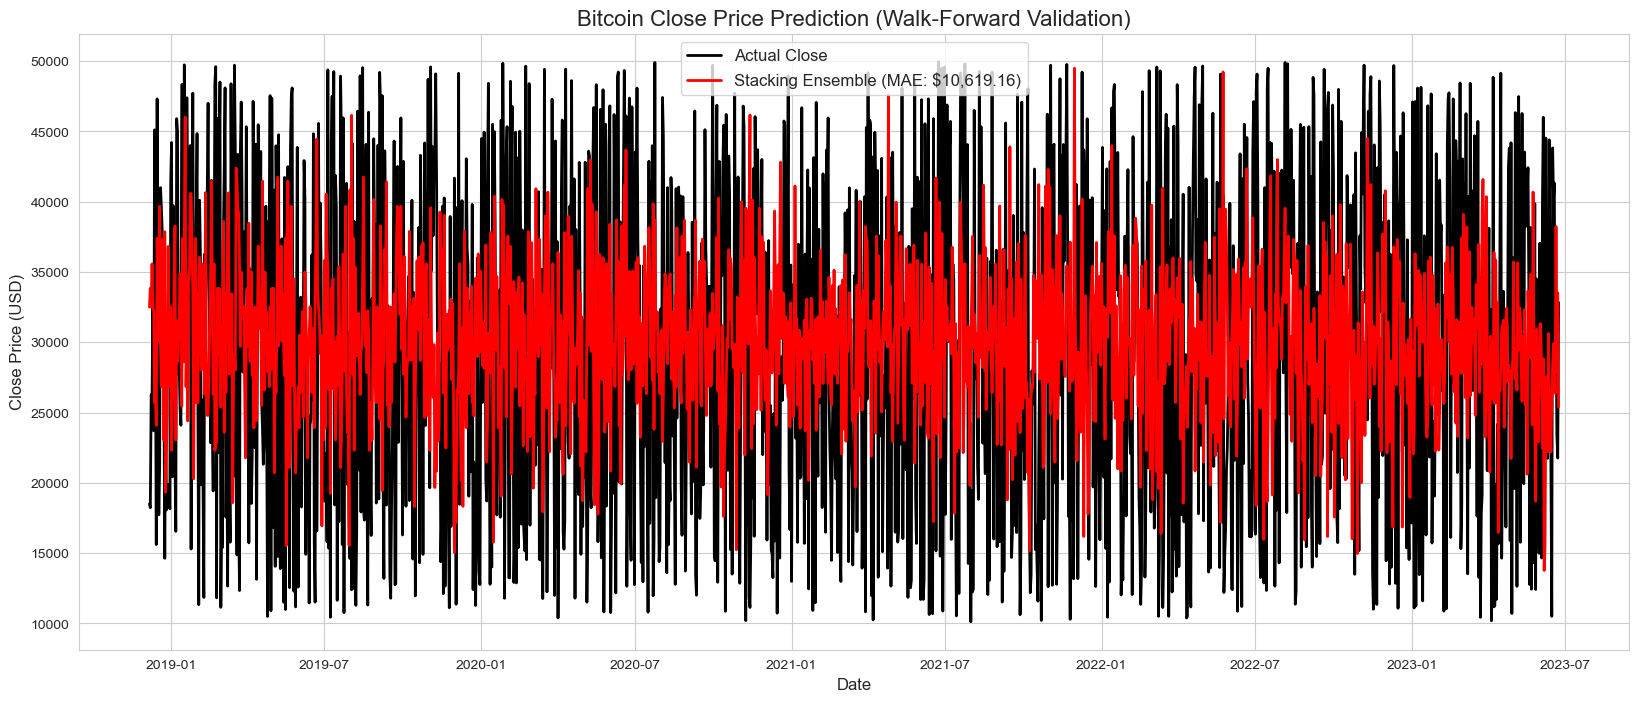

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(dates, y_true_real, label='Actual Close', color='black', linewidth=2)
plt.plot(dates, y_pred_stack_real, label=f'Stacking Ensemble (MAE: ${mae_stack:,.2f})', color='red', linewidth=2)

plt.title('Bitcoin Close Price Prediction (Walk-Forward Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

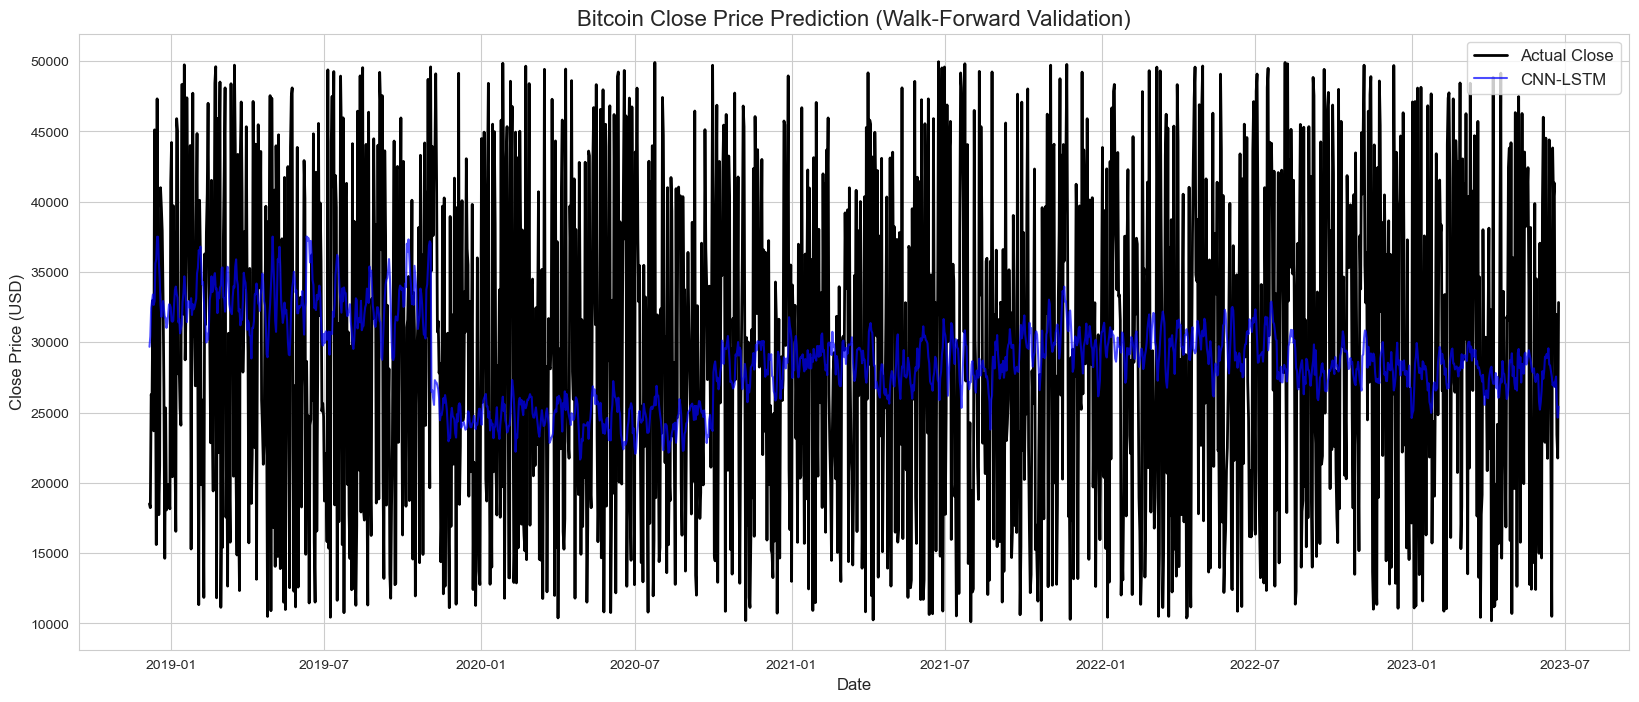

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(dates, y_true_real, label='Actual Close', color='black', linewidth=2)
plt.plot(dates, y_pred_cnn_real, label=f'CNN-LSTM', color='blue', alpha=0.7)

plt.title('Bitcoin Close Price Prediction (Walk-Forward Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

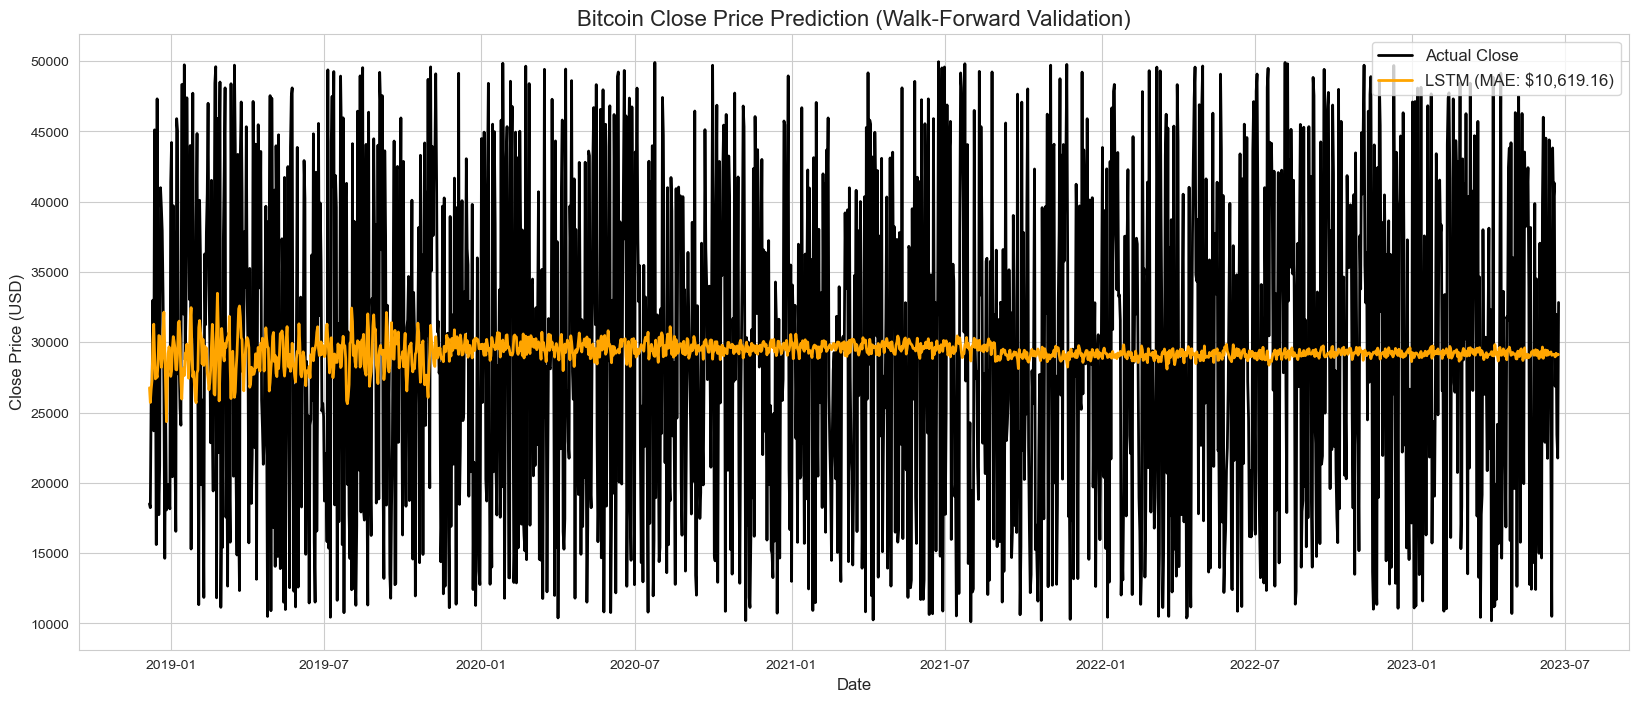

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(dates, y_true_real, label='Actual Close', color='black', linewidth=2)
plt.plot(dates, y_pred_lstm_real, label=f'LSTM (MAE: ${mae_stack:,.2f})', color='Orange', linewidth=2)

plt.title('Bitcoin Close Price Prediction (Walk-Forward Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()